In [1]:
import numpy as np 
import pandas as pd 
from scipy.stats import mode 
import matplotlib.pyplot as plt 
import seaborn as sns 
from sklearn.preprocessing import LabelEncoder 
from sklearn.model_selection import train_test_split, cross_val_score 
from sklearn.svm import SVC 
from sklearn.naive_bayes import GaussianNB 
from sklearn.ensemble import RandomForestClassifier 
from sklearn.metrics import accuracy_score, confusion_matrix

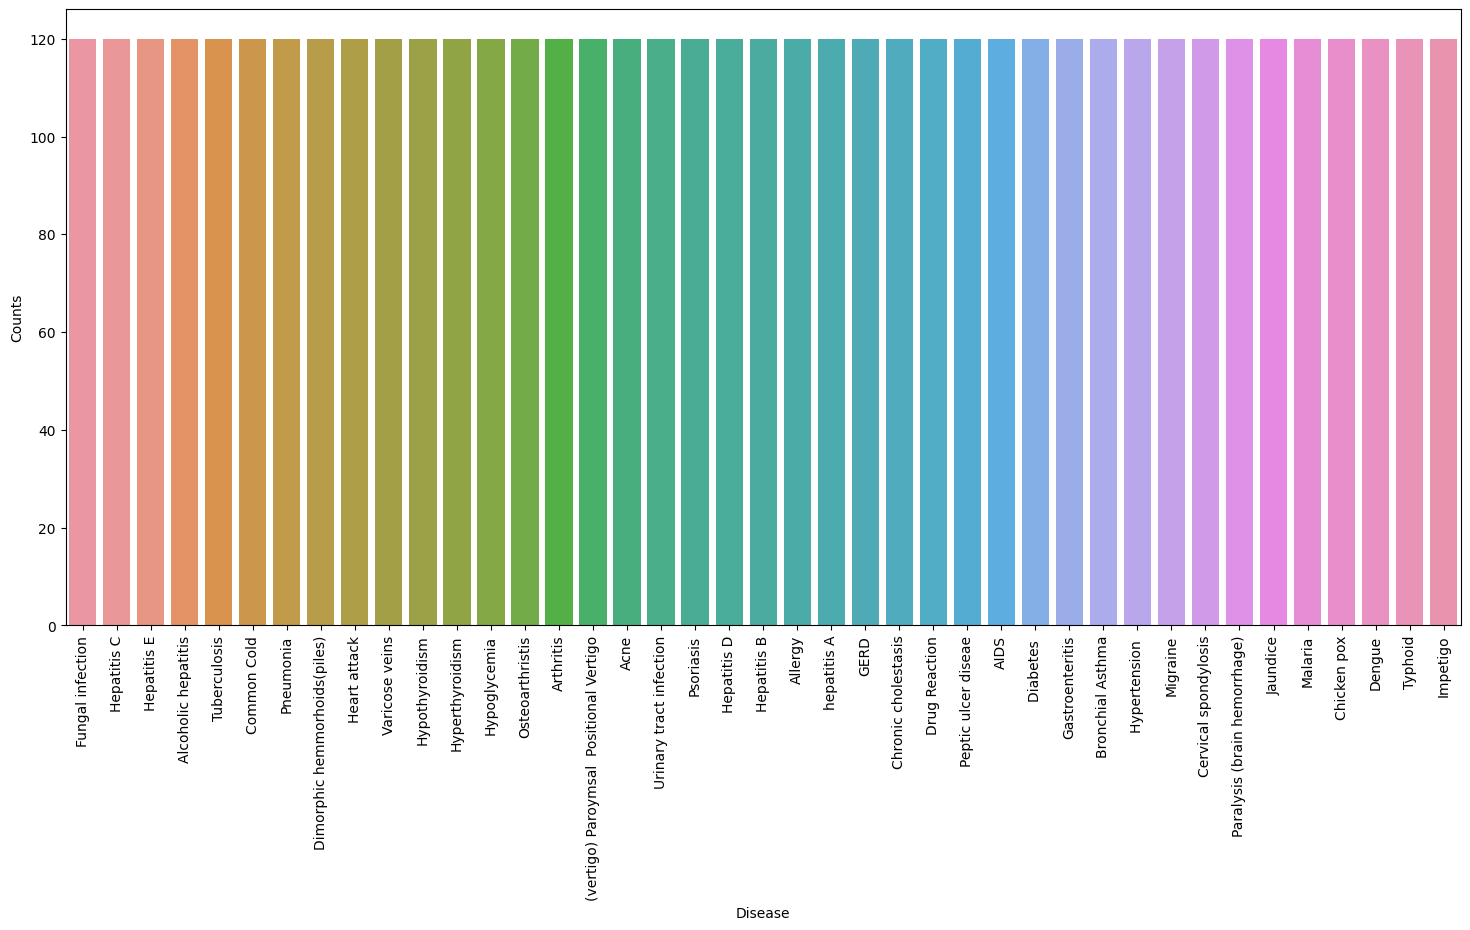

Train: (3936, 132), (3936,)
Test: (984, 132), (984,)


In [6]:
DATA_PATH = "datasets/Training.csv"
data = pd.read_csv(DATA_PATH).dropna(axis = 1)

disease_counts = data["prognosis"].value_counts() 
temp_df = pd.DataFrame({ 
    "Disease": disease_counts.index, 
    "Counts": disease_counts.values 
}) 

plt.figure(figsize = (18,8)) 
sns.barplot(x = "Disease", y = "Counts", data = temp_df) 
plt.xticks(rotation=90) 
plt.show()

encoder = LabelEncoder() 
data["prognosis"] = encoder.fit_transform(data["prognosis"]) 
X = data.iloc[:,:-1] 
y = data.iloc[:, -1] 
X_train, X_test, y_train, y_test = train_test_split( 
    X, y, test_size = 0.2, random_state = 24) 

print(f"Train: {X_train.shape}, {y_train.shape}") 
print(f"Test: {X_test.shape}, {y_test.shape}")


In [7]:
def cv_scoring(estimator, X, y): 
    return accuracy_score(y, estimator.predict(X)) 

models = { 
    "SVC": SVC(), 
    "Gaussian NB": GaussianNB(), 
    "Random Forest": RandomForestClassifier(random_state=18) 
} 

for model_name in models: 
    model = models[model_name] 
    scores = cross_val_score(model, X, y, cv=10, n_jobs=-1, scoring=cv_scoring) 
    print("=="*30) 
    print(model_name) 
    print(f"Scores: {scores}") 
    print(f"Mean Score: {np.mean(scores)}")


SVC
Scores: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
Mean Score: 1.0
Gaussian NB
Scores: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
Mean Score: 1.0
Random Forest
Scores: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
Mean Score: 1.0


In [8]:
final_svm_model = SVC() 
final_nb_model = GaussianNB() 
final_rf_model = RandomForestClassifier(random_state=18) 
final_svm_model.fit(X, y) 
final_nb_model.fit(X, y) 
final_rf_model.fit(X, y)


RandomForestClassifier(random_state=18)

/var/folders/k8/xpfg3jk135x9c1b_3hvhj9jm0000gn/T/ipykernel_10406/1212630877.py:9: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  final_preds = [mode([i,j,k])[0][0] for i,j,k in zip(svm_preds, nb_preds, rf_preds)]


Accuracy on Test dataset by the combined model: 100.0


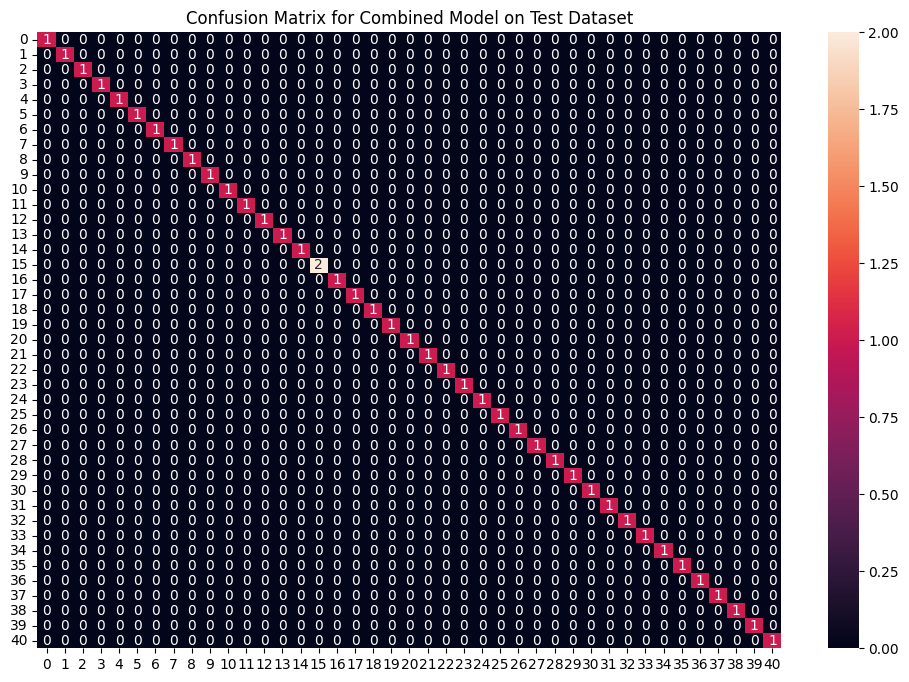

In [9]:
test_data = pd.read_csv("datasets/Testing.csv").dropna(axis=1)
test_X = test_data.iloc[:, :-1]
test_Y = encoder.transform(test_data.iloc[:, -1])

svm_preds = final_svm_model.predict(test_X) 
nb_preds = final_nb_model.predict(test_X) 
rf_preds = final_rf_model.predict(test_X) 

final_preds = [mode([i,j,k])[0][0] for i,j,k in zip(svm_preds, nb_preds, rf_preds)] 

print(f"Accuracy on Test dataset by the combined model: {accuracy_score(test_Y, final_preds)*100}")

cf_matrix = confusion_matrix(test_Y, final_preds)
plt.figure(figsize=(12,8))
sns.heatmap(cf_matrix, annot=True)
plt.title("Confusion Matrix for Combined Model on Test Dataset")
plt.show()


In [10]:
symptoms = X.columns.values 

symptom_index = {} 
for index, value in enumerate(symptoms): 
    symptom = " ".join([i.capitalize() for i in value.split("_")]) 
    symptom_index[symptom] = index 

data_dict = { 
    "symptom_index": symptom_index, 
    "predictions_classes": encoder.classes_
} 

def predictDisease(symptoms): 
    symptoms = symptoms.split(",") 
    input_data = [0] * len(data_dict["symptom_index"]) 
    for symptom in symptoms: 
        index = data_dict["symptom_index"][symptom] 
        input_data[index] = 1

    input_data = np.array(input_data).reshape(1,-1) 

    rf_prediction = data_dict["predictions_classes"][final_rf_model.predict(input_data)[0]] 
    nb_prediction = data_dict["predictions_classes"][final_nb_model.predict(input_data)[0]] 
    svm_prediction = data_dict["predictions_classes"][final_svm_model.predict(input_data)[0]] 
    final_prediction = mode([rf_prediction, nb_prediction, svm_prediction])[0][0] 
    predictions = { 
        "rf_model_prediction": rf_prediction, 
        "naive_bayes_prediction": nb_prediction, 
        "svm_model_prediction": svm_prediction, 
        "final_prediction": final_prediction 
    } 
    return predictions 

print(predictDisease("Itching,Skin Rash,Nodal Skin Eruptions"))


{'rf_model_prediction': 'Fungal infection', 'naive_bayes_prediction': 'Fungal infection', 'svm_model_prediction': 'Fungal infection', 'final_prediction': 'Fungal infection'}


/Users/shilpi/anaconda3/lib/python3.11/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/shilpi/anaconda3/lib/python3.11/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but GaussianNB was fitted with feature names
  warnings.warn(
/Users/shilpi/anaconda3/lib/python3.11/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(
/var/folders/k8/xpfg3jk135x9c1b_3hvhj9jm0000gn/T/ipykernel_10406/4294111643.py:25: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepte